## Assignment 6

In [81]:
%matplotlib inline

import numpy as np

import pystan
import stan_utility

import matplotlib
import matplotlib.pyplot as plt

font = {'size': 16}

matplotlib.rc('font', **font)

print('numpy', np.__version__)
print('pystan', pystan.__version__)

numpy 1.14.1
pystan 2.17.1.0


### 1. Linear model: drowning data with Stan

We load the data

In [2]:
data = np.loadtxt('../data/drowning.txt')

We define the stan-model (taken fran Stan-examples at github [1]) and fit it to data, including the generated quantity for the prediction

In [11]:
stan_code = """
data {
    int<lower=0> N; // number of data points
    vector[N] x;
    vector[N] y;
    real xpred;
}
parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}
transformed parameters {
    vector[N] mu;
    mu = alpha + beta*x;
}
model {
    y ~ normal(mu, sigma);
}
generated quantities {
    real ypred;
    vector[N] log_lik;
    ypred = normal_rng(alpha + beta*xpred, sigma);
    for (n in 1:N)
        log_lik[n] = normal_log(y[n], alpha + beta*x[n], sigma);
}
"""
xpred = 2016
stan_data= {
    'N': data.shape[0],
    'x': data[:,0],
    'y': data[:,1],
    'xpred': xpred
}

fit = pystan.stan(model_code=stan_code, data=stan_data, iter=1000, chains=4)
params = fit.extract()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_997bb79aa2e8967efdb8946fd62b2ee9 NOW.
c:\users\ncp\appdata\local\continuum\anaconda3\envs\stan_env\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


**i) What can you say about the trend in the number of people drown per year? Plot the histogram of the slope of the linear model.**

The trend $\beta$ has mean and central interval as below. I.e. we see the number of drownings is declining over time.

In [20]:
print('Mean   : {:>5.3f}'.format(np.mean(params['beta'])))
print('95% CI : {:>5.3f} - {:>5.3f}'.format(*np.percentile(params['beta'], q = [2.5, 97.5])))

Mean   : -3.296
95% CI : -4.278 - -2.209


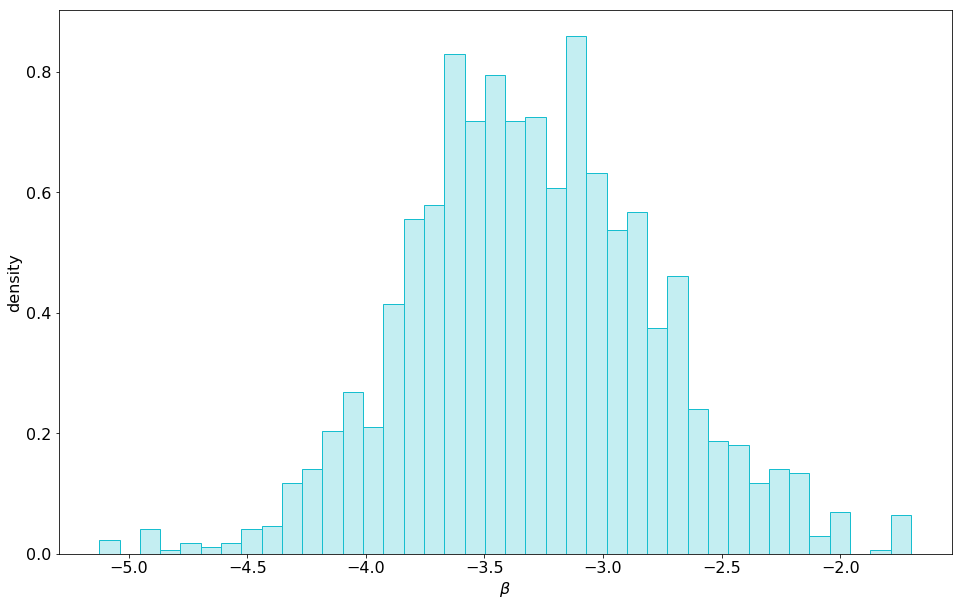

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (16, 10))
ax.hist(params['beta'], normed = True, bins = 40, fc=(23/255, 190/255, 207/255, 0.25), linestyle = '-', linewidth = 1, edgecolor = 'C9')
ax.set_xlabel(r'$\beta$')
ax.set_ylabel(r'density')
None

**ii) What does the model predict for year 2016? Plot the histogram of the posterior predictive distribution for number of people drown at $x = 2016$.**

The predicted value for 2017 $\mathit{ypred}$ has mean and central interval as below.

In [32]:
print('Mean   : {:>5.3f}'.format(np.mean(params['ypred'])))
print('95% CI : {:>5.3f} - {:>5.3f}'.format(*np.percentile(params['ypred'], q = [2.5, 97.5])))

Mean   : 156.221
95% CI : 97.354 - 219.131


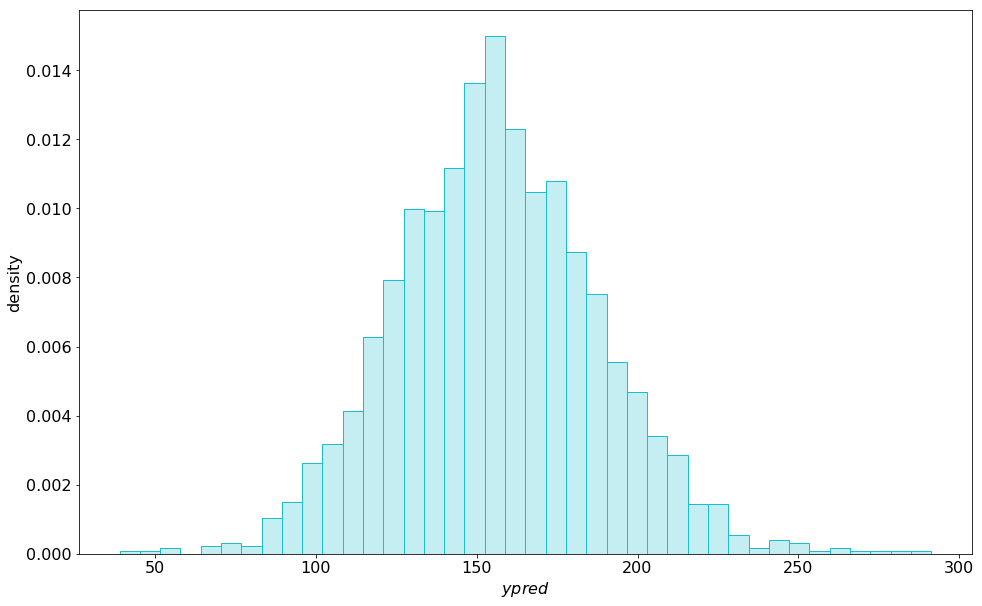

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (16, 10))
ax.hist(params['ypred'], normed = True, bins = 40, fc=(23/255, 190/255, 207/255, 0.25), linestyle = '-', linewidth = 1, edgecolor = 'C9')
ax.set_xlabel(r'$\mathit{ypred}$')
ax.set_ylabel(r'density')
None

### 2. Hierarchical model: factory data with Stan 

We load the data

In [35]:
data_factory = np.loadtxt('../data/factory.txt')

In [36]:
data_factory

array([[ 83., 117., 101., 105.,  79.,  57.],
       [ 92., 109.,  93., 119.,  97.,  92.],
       [ 92., 114.,  92., 116., 103., 104.],
       [ 46., 104.,  86., 102.,  79.,  77.],
       [ 67.,  87.,  67., 116.,  92., 100.]])

We transform the data to a flat vector, with x mapping the sample number to the group.

In [58]:
x = np.tile(np.arange(1, data_factory.shape[1] + 1), data_factory.shape[0])
y = data_factory.flatten()
N = len(x)
K = np.max(x)

Utility functions:

In [164]:
def explain(params):
    mu = params['mu']
    if mu.ndim == 1:
        mu = mu[:,np.newaxis]
        
    print('i) ')
    print('     Posterior Mean for 6th machine    : {:>5.3f}'.format(np.mean(mu[:,-1])))
    print('     Posterior 95% CI for 6th machine  : {:>5.3f} - {:>5.3f}'.format(*np.percentile(mu[:,-1], q = [2.5, 97.5])))
    print('ii)')
    print('     Predictive Mean for 6th machine   : {:>5.3f}'.format(np.mean(params['ypred'])))
    print('     Predictive 95% CI for 6th machine : {:>5.3f} - {:>5.3f}'.format(*np.percentile(params['ypred'], q = [2.5, 97.5])))
    print('iIi)')
    print('     Posterior Mean for 7th machine    : {:>5.3f}'.format(np.mean(mu)))
    print('     Posterior 95% CI for 7th machine  : {:>5.3f} - {:>5.3f}'.format(*np.percentile(np.mean(mu, axis = 1), q = [2.5, 97.5])))
    print()
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (16, 6))
    ax[0].set_title('6th machine Posterior Mean')
    ax[0].hist(mu[:,-1], normed = True, bins = 40, fc=(23/255, 190/255, 207/255, 0.25), linestyle = '-', linewidth = 1, edgecolor = 'C9')
    ax[0].set_xlabel(r'$\mu_6$')
    ax[0].set_ylabel(r'density')
    ax[1].set_title('6th machine Predictive Mean')
    ax[1].hist(params['ypred'], normed = True, bins = 40, fc=(23/255, 190/255, 207/255, 0.25), linestyle = '-', linewidth = 1, edgecolor = 'C9')
    ax[1].set_xlabel(r'$\hat{\mu}_6$')
    ax[2].set_title('7th machine Posterior Mean')
    ax[2].hist(np.mean(mu, axis = 1), normed = True, bins = 40, fc=(23/255, 190/255, 207/255, 0.25), linestyle = '-', linewidth = 1, edgecolor = 'C9')
    ax[2].set_xlabel(r'$\mu_7$')

#### 2.1 Seperate model
For the seperate model we fit each machine using independent $\mu_j$ and $\sigma_j$:

In [121]:
stan_code = """
data {
  int<lower=0> N;            // number of data points
  int<lower=0> K;            // number of groups
  int<lower=1,upper=K> x[N]; // group indicator
  vector[N] y;               // target
}
parameters {
  vector[K] mu;              // group means
  vector<lower=0>[K] sigma;  // group std
}
model {
  y ~ normal(mu[x], sigma[x]);
}
generated quantities {
    real ypred;
    ypred = normal_rng(mu[K], sigma[K]);
}
"""

In [122]:
fit_seperate = pystan.stan(
    model_code=stan_code,
    data={
        'N': N,
        'K': K,
        'x': x,
        'y': y,
    }, iter=2000, chains=4)
params_seperate = fit_seperate.extract()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_48f83b230bc85be7a5c31a652e46441b NOW.
c:\users\ncp\appdata\local\continuum\anaconda3\envs\stan_env\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


We check the fitted parameters and the performance of the fit, i.e. the treedepth, E-BFMI, and divergences:

In [128]:
stan_utility.check_treedepth(fit_seperate)
stan_utility.check_energy(fit_seperate)
stan_utility.check_div(fit_seperate)

0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
0.0 of 4000 iterations ended with a divergence (0.0%)


We print and plot the results

i) 
     Posterior Mean for 6th machine    : 86.522
     Posterior 95% CI for 6th machine  : 54.965 - 117.463
ii)
     Predictive Mean for 6th machine   : 86.624
     Predictive 95% CI for 6th machine : 14.482 - 168.535
iIi)
     Posterior Mean for 7th machine    : 93.036
     Posterior 95% CI for 7th machine  : 83.383 - 103.065



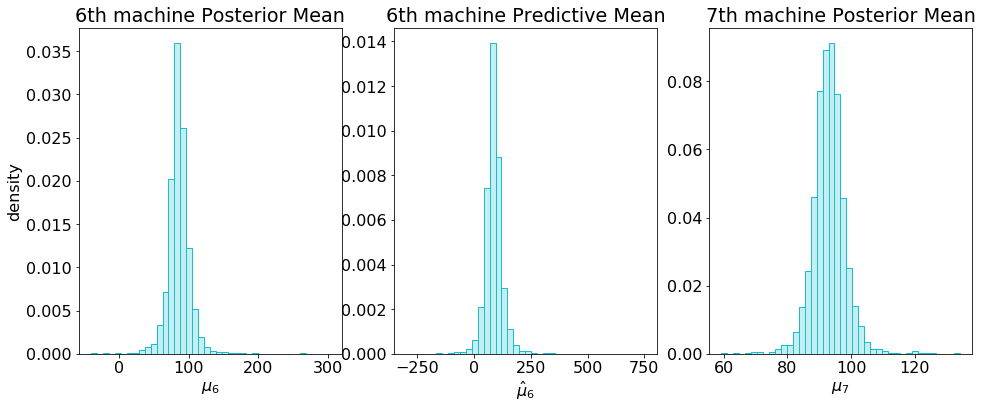

In [165]:
explain(params_seperate)

#### 2.2 Pooled model
For the pooled model we fit all as a single machine, e.g. $x_j = 1$ for all $j = 1 \ldots 6$, and $K = 1$.

In [135]:
x_pooled = np.array([1] * len(y))

In [136]:
fit_pooled = pystan.stan(
    model_code=stan_code,
    data={
        'N': N,
        'K': 1,
        'x': x_pooled,
        'y': y,
    }, iter=2000, chains=4)
params_pooled = fit_pooled.extract()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_48f83b230bc85be7a5c31a652e46441b NOW.
c:\users\ncp\appdata\local\continuum\anaconda3\envs\stan_env\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


We check the fitted parameters and the performance of the fit, i.e. the treedepth, E-BFMI, and divergences:

In [167]:
stan_utility.check_treedepth(fit_pooled)
stan_utility.check_energy(fit_pooled)
stan_utility.check_div(fit_pooled)

0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
0.0 of 4000 iterations ended with a divergence (0.0%)


We print and plot the results

i) 
     Posterior Mean for 6th machine    : 93.035
     Posterior 95% CI for 6th machine  : 86.350 - 100.089
ii)
     Predictive Mean for 6th machine   : 93.264
     Predictive 95% CI for 6th machine : 55.251 - 130.992
iIi)
     Posterior Mean for 7th machine    : 93.035
     Posterior 95% CI for 7th machine  : 86.350 - 100.089



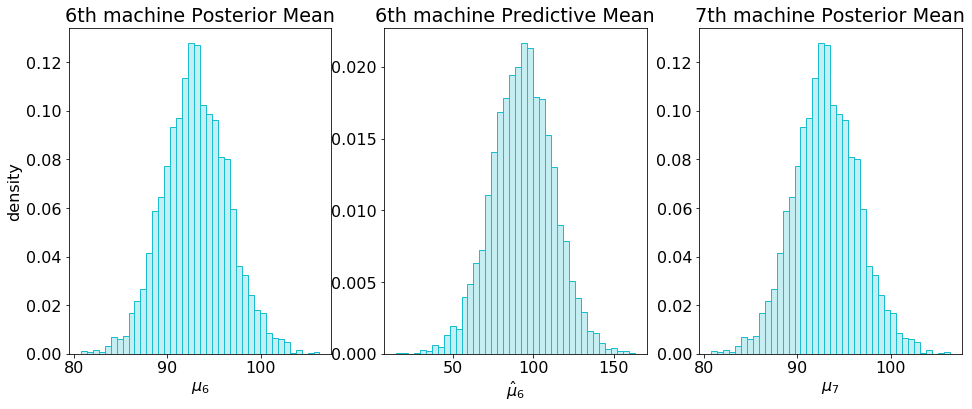

In [166]:
explain(params_pooled)

#### Hierarchical model

In [179]:
stan_code_hierarchical = """
data {
  int<lower=0> N;            // number of data points
  int<lower=0> K;            // number of groups
  int<lower=1,upper=K> x[N]; // group indicator
  vector[N] y;               // target
}
parameters {
  real mu_prior;             // shared prior mean
  real<lower=0> sigma_prior; // shared prior std
  vector[K] mu;              // group means
  real<lower=0> sigma;       // shared std
}
model {
  for (k in 1:K) {
    mu[k] ~ normal(mu_prior, sigma_prior);
  }
  y ~ normal(mu[x], sigma);
}
generated quantities {
    real ypred;
    ypred = normal_rng(mu[K], sigma);
}
"""

In [180]:
fit_hierarchical = pystan.stan(
    model_code=stan_code_hierarchical,
    data={
        'N': N,
        'K': K,
        'x': x,
        'y': y,
    }, iter=2000, chains=4)
params_hierarchical = fit_seperate.extract()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1848b949df4e2fe194673189a89c74a7 NOW.
c:\users\ncp\appdata\local\continuum\anaconda3\envs\stan_env\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


We check the fitted parameters and the performance of the fit, i.e. the treedepth, E-BFMI, and divergences:

In [183]:
stan_utility.check_treedepth(fit_hierarchical)
stan_utility.check_energy(fit_hierarchical)
stan_utility.check_div(fit_hierarchical)

0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
14.0 of 4000 iterations ended with a divergence (0.35%)
Try running with larger adapt_delta to remove the divergences


We see some iterations ended with a divergence, but since it is such small fraction, we accept the performance.

We print and plot the results

i) 
     Posterior Mean for 6th machine    : 87.786
     Posterior 95% CI for 6th machine  : 75.395 - 100.290
ii)
     Predictive Mean for 6th machine   : 87.651
     Predictive 95% CI for 6th machine : 53.801 - 120.618
iIi)
     Posterior Mean for 7th machine    : 93.066
     Posterior 95% CI for 7th machine  : 87.357 - 98.849



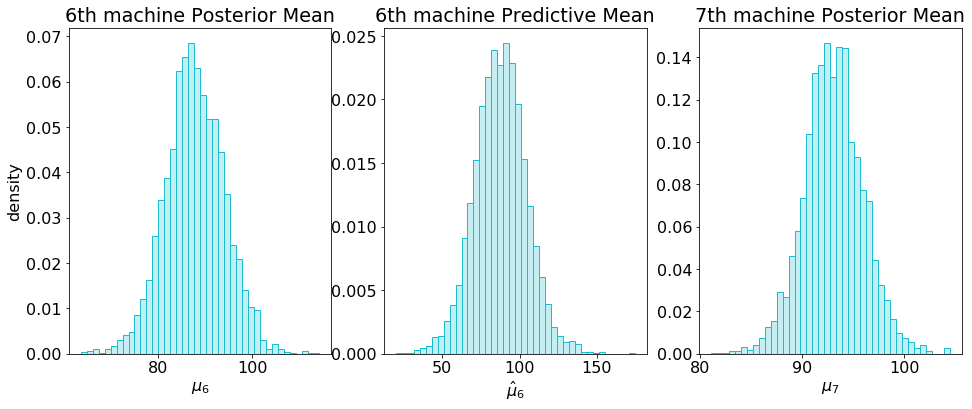

In [184]:
explain(fit_hierarchical)

#### Conclusions

In the seperate model, we see the uncertainty is relatively high, since only use 5 measurements for each machine seperately. The resuls in wider uncertainty intervals (CI and PI). In the pooled model, differences in the machines are somewhat lost, and we predict the tree means very close. The we assume all machines are identical, the 7th machine should work exactly as the 6th.

The hierarchical model combines the best of the to models.  We assume that all machines share some prior distribution. It allows the machines to be different, but uses the uncertainty across all measurements. The results is much narrower uncertainty intervals (CI and PI).

### References

[1] Stan Examples at GitHub, [https://github.com/avehtari/BDA_py_demos/blob/master/demos_pystan/pystan_demo.ipynb](https://github.com/avehtari/BDA_py_demos/blob/master/demos_pystan/pystan_demo.ipynb)